In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

plt.ioff()


class Backtest:
    def __init__(self, actual, forecast, alpha):
        self.index = actual.index
        self.actual = actual.values
        self.forecast = forecast.values
        self.alpha = alpha

    def hit_series(self):
        return (self.actual < self.forecast) * 1

    def number_of_hits(self):
        return self.hit_series().sum()

    def hit_rate(self):
        return self.hit_series().mean()

    def expected_hits(self):
        return self.actual.size * self.alpha

    def duration_series(self):
        hit_series = self.hit_series()
        hit_series[0] = 1
        hit_series[-1] = 1
        return np.diff(np.where(hit_series == 1))[0]

    def plot(self, file_name=None):

        # Re-add the time series index
        r = pd.Series(self.actual, index=self.index)
        q = pd.Series(self.forecast, index=self.index)

        sns.set_context("paper")
        sns.set_style("whitegrid", {"font.family": "serif", "font.serif": "Computer Modern Roman", "text.usetex": True})

        # Hits
        ax = r[r <= q].plot(color="red", marker="o", ls="None", figsize=(6, 3.5))
        for h in r[r <= q].index:
            plt.axvline(h, color="black", alpha=0.4, linewidth=1, zorder=0)

        # Positive returns
        r[q < r].plot(ax=ax, color="green", marker="o", ls="None")

        # Negative returns but no hit
        r[(q <= r) & (r <= 0)].plot(ax=ax, color="orange", marker="o", ls="None")

        # VaR
        q.plot(ax=ax, grid=False, color="black", rot=0)

        # Axes
        plt.xlabel("")
        plt.ylabel("Log Return")
        ax.yaxis.grid()

        sns.despine()
        if file_name is None:
            plt.show()
        else:
            plt.savefig(file_name, bbox_inches="tight")
        plt.close("all")

    def tick_loss(self, return_mean=True):
        loss = (self.alpha - self.hit_series()) * (self.actual - self.forecast)
        if return_mean:
            return loss.mean()
        else:
            return loss

    def smooth_loss(self, delta=25, return_mean=True):
        """Gonzalez-Rivera, Lee and Mishra (2004)"""
        loss = ((self.alpha - (1 + np.exp(delta*(self.actual - self.forecast)))**-1) * (self.actual - self.forecast))
        if return_mean:
            return loss.mean()
        else:
            return loss

    def quadratic_loss(self, return_mean=True):
        """Lopez (1999); Martens et al. (2009)"""
        loss = (self.hit_series() * (1 + (self.actual - self.forecast)**2))
        if return_mean:
            return loss.mean()
        else:
            return loss

    def firm_loss(self, c=1, return_mean=True):
        """Sarma et al. (2003)"""
        loss = (self.hit_series() * (1 + (self.actual - self.forecast)**2) - c*(1-self.hit_series()) * self.forecast)
        if return_mean:
            return loss.mean()
        else:
            return loss

    def lr_bt(self):
        """Likelihood ratio framework of Christoffersen (1998)"""
        hits = self.hit_series()   # Hit series
        tr = hits[1:] - hits[:-1]  # Sequence to find transitions

        # Transitions: nij denotes state i is followed by state j nij times
        n01, n10 = (tr == 1).sum(), (tr == -1).sum()
        n11, n00 = (hits[1:][tr == 0] == 1).sum(), (hits[1:][tr == 0] == 0).sum()

        # Times in the states
        n0, n1 = n01 + n00, n10 + n11
        n = n0 + n1

        # Probabilities of the transitions from one state to another
        p01, p11 = n01 / (n00 + n01), n11 / (n11 + n10)
        p = n1 / n

        if n1 > 0:
            # Unconditional Coverage
            uc_h0 = n0 * np.log(1 - self.alpha) + n1 * np.log(self.alpha)
            uc_h1 = n0 * np.log(1 - p) + n1 * np.log(p)
            uc = -2 * (uc_h0 - uc_h1)

            # Independence
            ind_h0 = (n00 + n01) * np.log(1 - p) + (n01 + n11) * np.log(p)
            ind_h1 = n00 * np.log(1 - p01) + n01 * np.log(p01) + n10 * np.log(1 - p11)
            if p11 > 0:
                ind_h1 += n11 * np.log(p11)
            ind = -2 * (ind_h0 - ind_h1)

            # Conditional coverage
            cc = uc + ind

            # Stack results
            df = pd.concat([pd.Series([uc, ind, cc]),
                            pd.Series([1 - stats.chi2.cdf(uc, 1),
                                       1 - stats.chi2.cdf(ind, 1),
                                       1 - stats.chi2.cdf(cc, 2)])], axis=1)
        else:
            df = pd.DataFrame(np.zeros((3, 2))).replace(0, np.nan)

        # Assign names
        df.columns = ["Statistic", "p-value"]
        df.index = ["Unconditional", "Independence", "Conditional"]

        return df

    def dq_bt(self, hit_lags=4, forecast_lags=1):
        """Dynamic Quantile Test (Engle & Manganelli, 2004)"""
        try:
            hits = self.hit_series()
            p, q, n = hit_lags, forecast_lags, hits.size
            pq = max(p, q - 1)
            y = hits[pq:] - self.alpha  # Dependent variable
            x = np.zeros((n - pq, 1 + p + q))
            x[:, 0] = 1  # Constant

            for i in range(p):  # Lagged hits
                x[:, 1 + i] = hits[pq-(i+1):-(i+1)]

            for j in range(q):  # Actual + lagged VaR forecast
                if j > 0:
                    x[:, 1 + p + j] = self.forecast[pq-j:-j]
                else:
                    x[:, 1 + p + j] = self.forecast[pq:]

            beta = np.dot(np.linalg.inv(np.dot(x.T, x)), np.dot(x.T, y))
            lr_dq = np.dot(beta, np.dot(np.dot(x.T, x), beta)) / (self.alpha * (1-self.alpha))
            p_dq = 1 - stats.chi2.cdf(lr_dq, 1+p+q)

        except:
            lr_dq, p_dq = np.nan, np.nan

        return pd.Series([lr_dq, p_dq],
                         index=["Statistic", "p-value"], name="DQ")

In [5]:
actuals = pd.read_excel('DR.xlsx', index_col=0, parse_dates=[0]).fillna(0.0)
actuals.columns = ['ICBC', 'HSBC', 'Lloyds', 'BNP', 'DB', 'RBS']
actuals.head()

,ICBC,HSBC,Lloyds,BNP,DB,RBS
Date,,,,,,
2008-08-05,0.000000,-0.030238,-0.015830,-0.048955,-0.013225,-9.014434
2008-08-06,-0.003472,0.013269,0.023018,0.006108,0.000646,0.456810
2008-08-07,0.005235,0.012334,-0.096302,0.004193,-0.010222,-1.319985
2008-08-08,0.003504,-0.007394,-0.023228,-0.013104,-0.018728,-1.343147
2008-08-11,0.028828,-0.002298,-0.014116,0.038186,0.004328,-0.251297


In [28]:
hist = pd.read_csv('hist_var.csv', index_col=0, parse_dates=[0])
mc = pd.read_csv('mc_var.csv', index_col=0, parse_dates=[0])
norm = pd.read_csv('norm_var.csv', index_col=0, parse_dates=[0])

In [7]:
actuals = actuals.loc[hist.index, :]

In [39]:
def backtest(bank, alpha=0.05, hist=hist, mc=mc, norm=norm):
    bt_hist = Backtest(actual=actuals[bank], forecast=hist[bank], alpha=alpha)
    bt_mc = Backtest(actual=actuals[bank], forecast=mc[bank], alpha=alpha)
    bt_norm = Backtest(actual=actuals[bank], forecast=norm[bank], alpha=alpha)
    print('LR test results')
    print(bt_hist.lr_bt())
    print(bt_mc.lr_bt())
    print(bt_norm.lr_bt())
    
    print('DQ test results')
    print(bt_hist.dq_bt())
    print(bt_mc.dq_bt())
    print(bt_norm.dq_bt())
    
    #bt_hist.plot()
    #bt_mc.plot()
    #bt_norm.plot()
    
    

In [44]:
backtest('RBS')

LR test results
                  Statistic  p-value
Unconditional  12029.587217      0.0
Independence            NaN      NaN
Conditional             NaN      NaN
                  Statistic  p-value
Unconditional  12486.902583      0.0
Independence            NaN      NaN
Conditional             NaN      NaN
                  Statistic  p-value
Unconditional  12526.898666      0.0
Independence            NaN      NaN
Conditional             NaN      NaN
DQ test results
Statistic    38644.288914
p-value          0.000000
Name: DQ, dtype: float64
Statistic    40030.715561
p-value          0.000000
Name: DQ, dtype: float64
Statistic    40148.841315
p-value          0.000000
Name: DQ, dtype: float64


c:\users\yunlin\miniconda3\envs\py3k\lib\site-packages\ipykernel_launcher.py:126: RuntimeWarning: divide by zero encountered in log
c:\users\yunlin\miniconda3\envs\py3k\lib\site-packages\ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in multiply
c:\users\yunlin\miniconda3\envs\py3k\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
c:\users\yunlin\miniconda3\envs\py3k\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
c:\users\yunlin\miniconda3\envs\py3k\lib\site-packages\scipy\stats\_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


In [ ]:
bt.dq_bt()

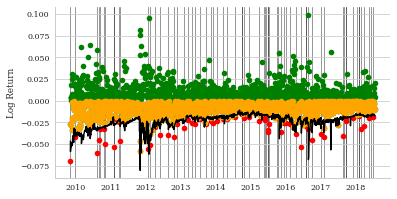

In [27]:
bt.plot()